In [1]:
addpath ~/npl
startupJupyter

In [2]:
desktop

In [39]:
td = TrialData.buildEmptyWithTrialDurations(repmat(T, N, 1));

In [40]:
td = td.addSpikeArrayChannel('A', 'electrodes', 1:U, 'spikes', spikes);

In [43]:
td = td.setSpikeArrayTrialMask('A', mask)

In [44]:
td.getSpikeArrayTrialMask('A')

# Faster PSTH calculation

## Light, for testing

In [4]:
R = 50; % trials (total)
U = 5; % units
C = 4; % conditions
T = 500; % timepoints

## Heavy for profiling

In [15]:
R = 500; % trials (total)
U = 500; % units
C = 50; % conditions
T = 1000; % timepoints

In [16]:
A = 60; % amplitmaude
freq = 2;
tvec = (1:T) / T * 1000;
dt = 1/T;
phi = linspace(0, pi, C)';
condition_rates = A * sin(tvec.*(2*pi).*freq./1000 + phi); % c x t
biases = shiftdim(A * linspace(0, 1, U), -2);
rates = max(0, condition_rates + biases); % c x t x u

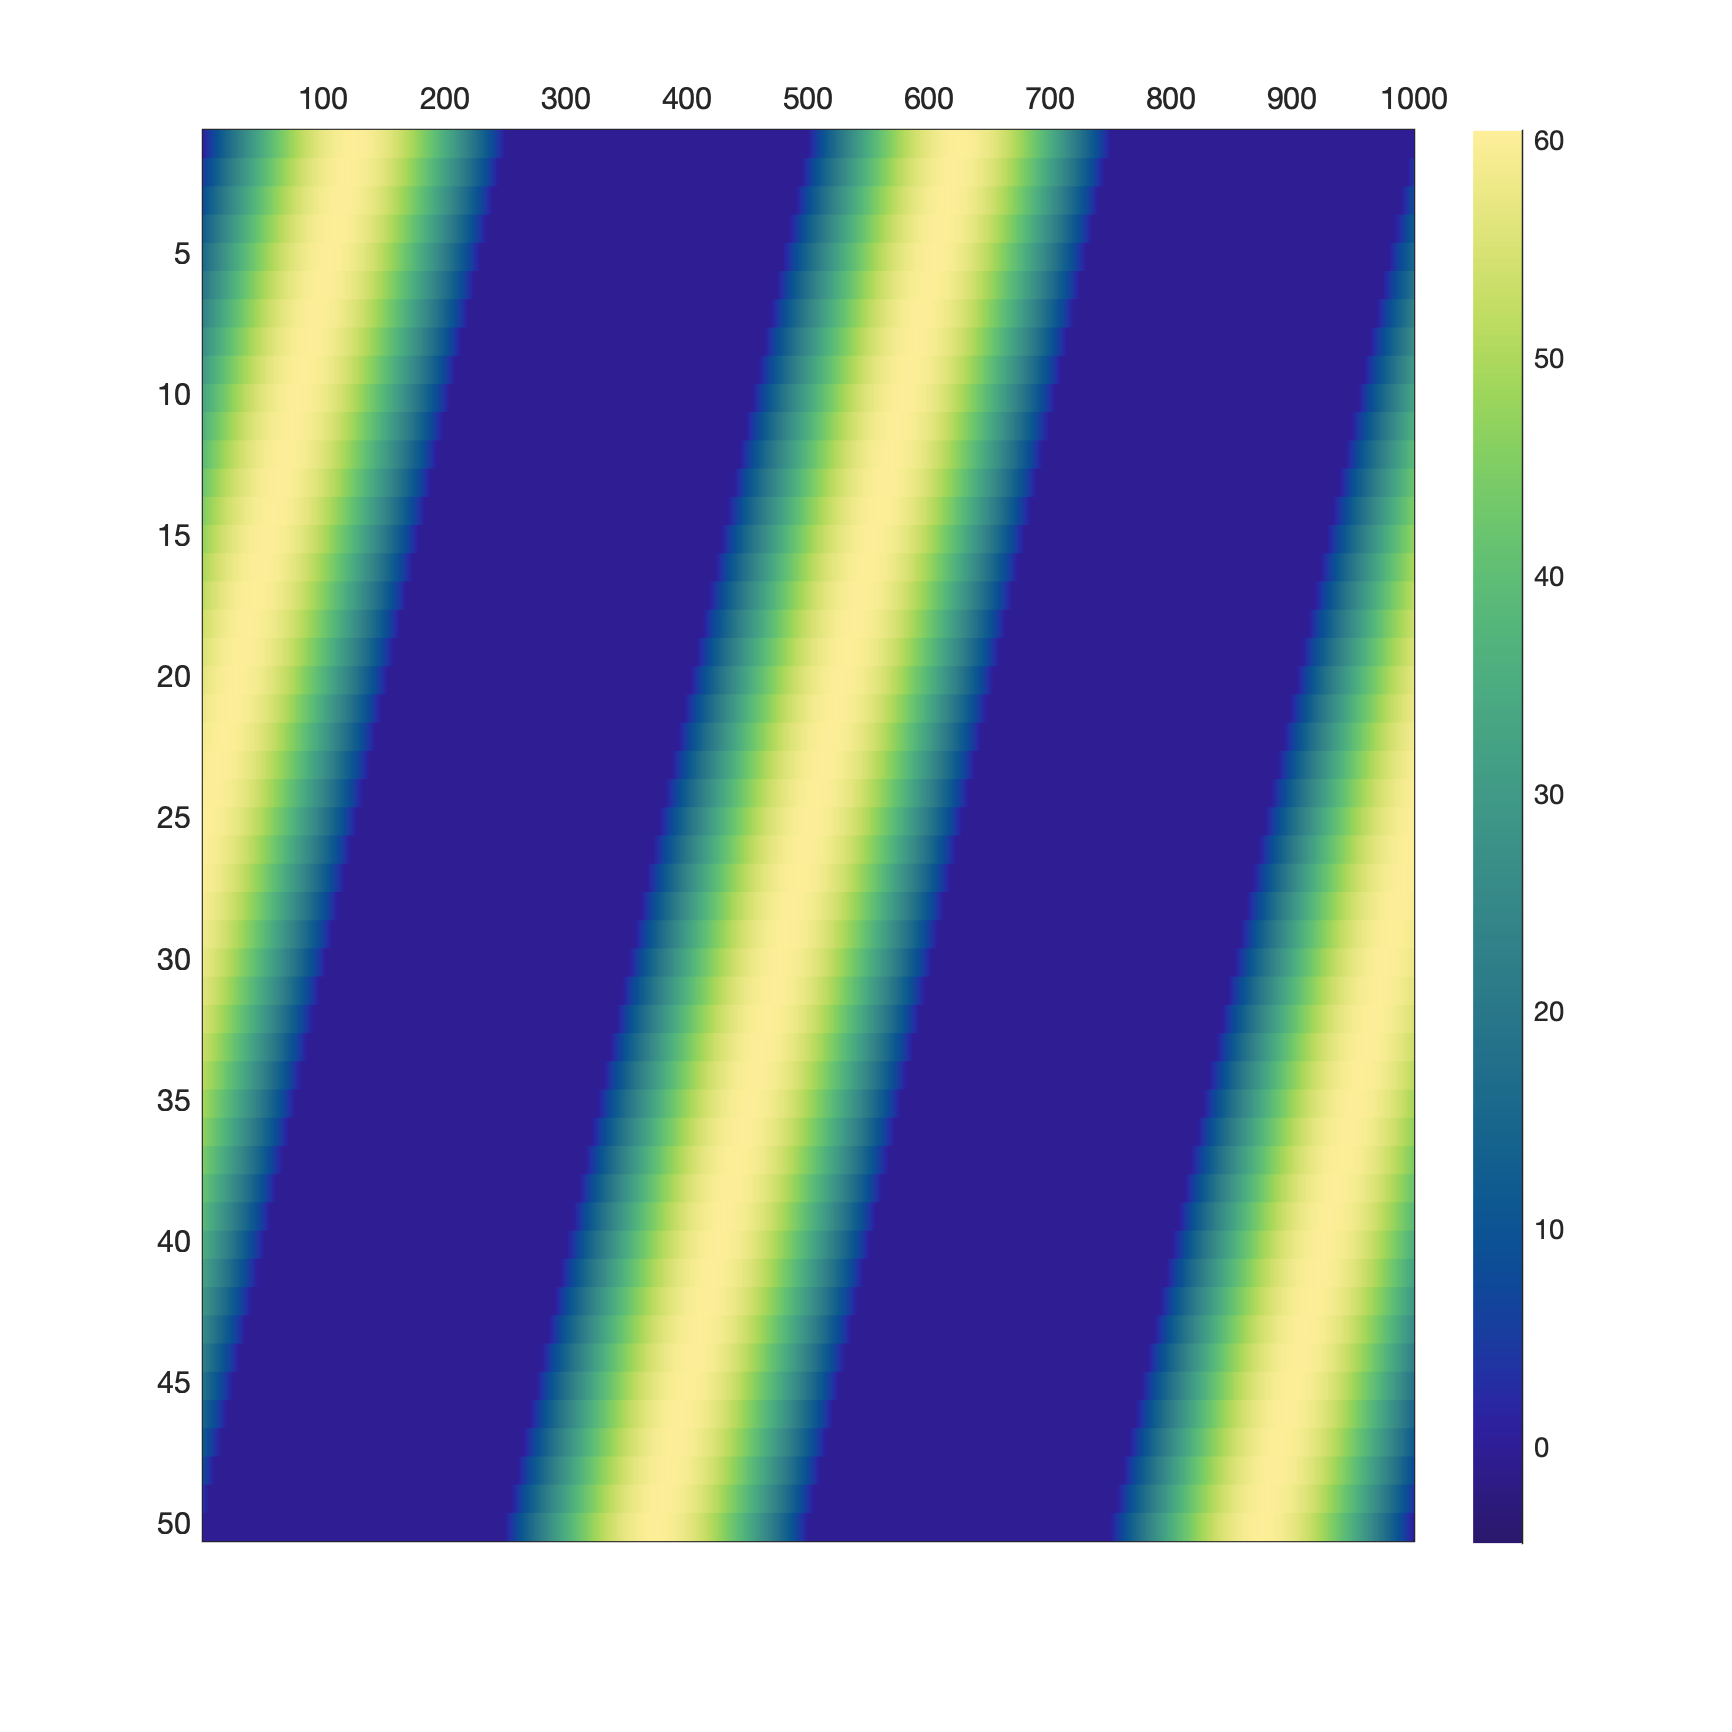

In [13]:
pmat(rates(:, :, 4), 'x', tvec);

In [94]:
cond = randi(C, R, 1); % which condition is each trial
spikes = cell(R, U);
prog = ProgressBar(R, 'Choosing spikes');
for r = 1:R
    prog.update(r);
    for u = 1:U
        % generate spikes at 0 offset and 0.5 ms offset
        spikes{r, u} = [tvec(poissrnd(rates(cond(r), :, u) / 2 .* dt) > 0)'; ...
                        tvec(poissrnd(rates(cond(r), :, u) / 2 .* dt) > 0)' + 0.5]; 
    end
end
prog.finish();


In [17]:
cond = randi(C, R, 1); % which condition is each trial
spikes = cell(R, U);
prog = ProgressBar(R, 'Choosing spikes');
for r = 1:R
    prog.update(r);
    % generate spikes at 0 offset and 0.5 ms offset
    [spikes{r, :}] = deal([tvec(poissrnd(rates(cond(r), :, 1) / 2 .* dt) > 0)'; ...
                           tvec(poissrnd(rates(cond(r), :, 1) / 2 .* dt) > 0)' + 0.5]); 
end
prog.finish();


In [18]:
conditions = cond;
t_start_delta_stop = [1 1 T];
filterFn = @(x) normpdf(x, 0, 20);
filterWindow = [-60 60];
trial_valid = repmat([-70 T+70], R, 1);

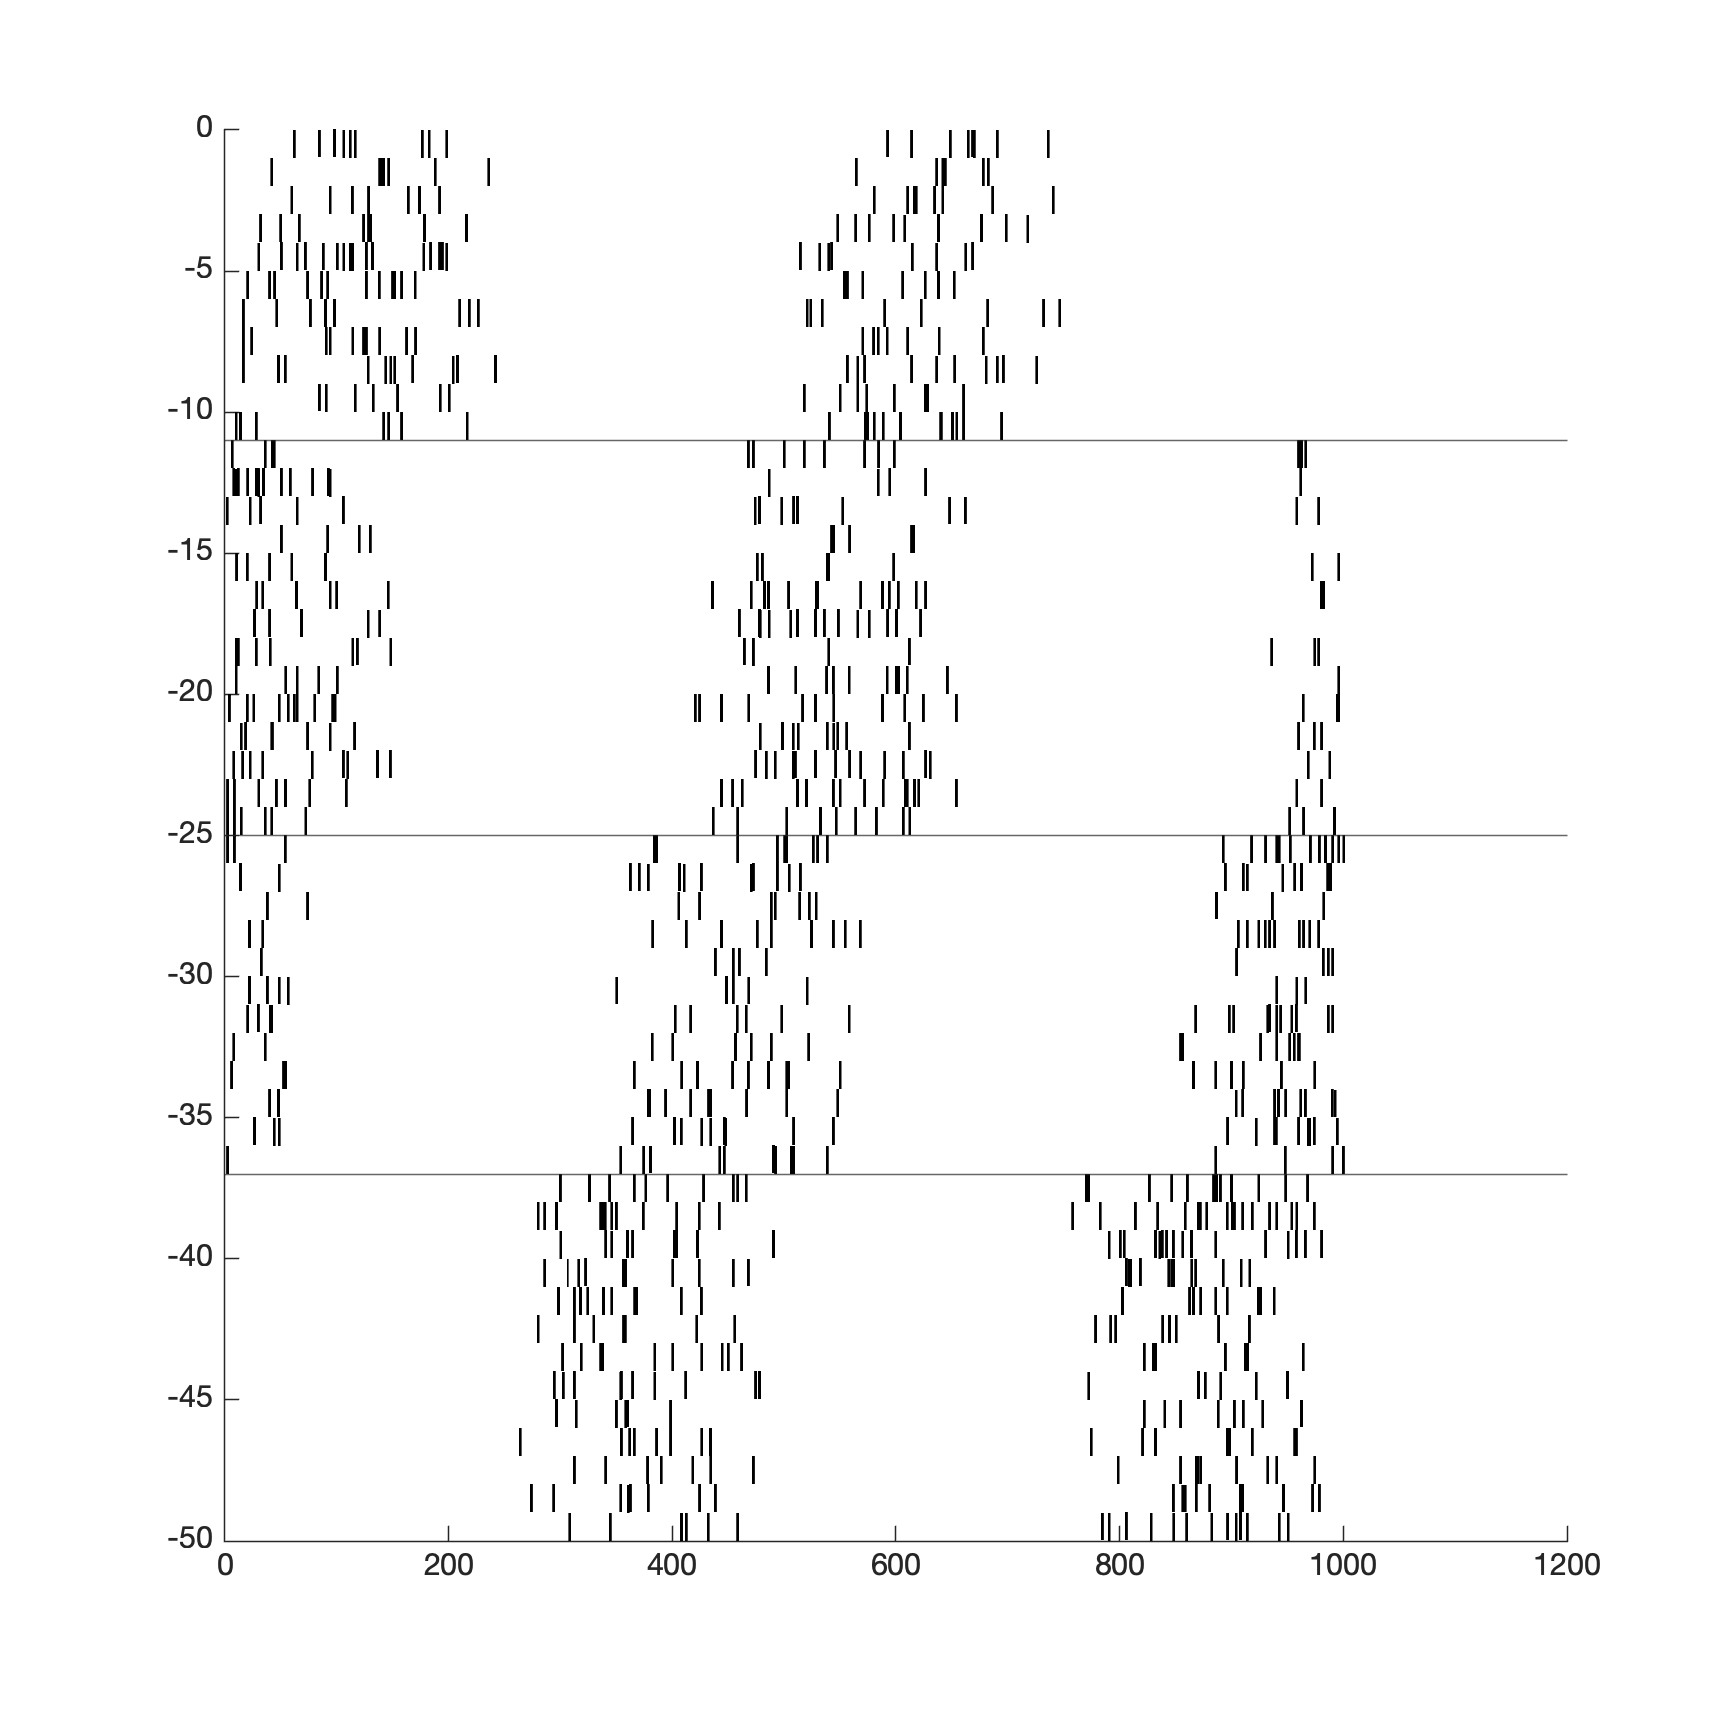

In [10]:
[~, trial_sort] = sort(cond);
TrialDataUtilities.Plotting.drawTickRaster(spikes(trial_sort, 1)')
hold on;
yv = find(diff(cond(trial_sort)));
for i = 1:numel(yv), yline(-yv(i)); end

In [19]:
[cond_avg_CxTxU, n_trials_CxT, cond_sem_CxTxU, single_trial_RxTxU] = fastPSTH3(spikes, conditions, t_start_delta_stop, filterFn, filterWindow, trial_valid);

In [8]:
sf = GaussianSpikeFilter(20);